In [1]:
import json

In [2]:
with open('csvs/google_topics.json', 'r+', encoding='utf-8') as f:
    google_topic = json.loads(f.read())

In [3]:
with open('csvs/gdelt_topics.json', 'r+', encoding='utf-8') as f:
    gdelt_topic = json.loads(f.read())

In [4]:
google_topic_set = [set(i) for i in google_topic]
gdelt_topic_set = [set(i) for i in gdelt_topic]

In [7]:
[set.intersection(google_topic_set[i], gdelt_topic_set[i]) for i in range(len(google_topic))]

[{'semiconductor'},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {'volkswagen'},
 set(),
 set()]

In [ ]:
# ====================== Graph ==========================

In [1]:
import json
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

import itertools

Using backend: pytorch


In [2]:
with open('csvs/updated_thirty_freq_company_names.json', 'r+', encoding='utf-8') as f:
    thirty_sorted_freq_dict_google = json.loads(f.read())

In [3]:
with open('csvs/updated_thirty_freq_company_names_gdlet.json', 'r+', encoding='utf-8') as f:
    thirty_sorted_freq_dict_gdlet = json.loads(f.read())

In [4]:
gdlet_set = set(thirty_sorted_freq_dict_gdlet.keys())
google_set = set(thirty_sorted_freq_dict_google.keys())

In [5]:
set.intersection(gdlet_set, google_set)

{'Apple', 'Ford', 'Intel', 'MIT', 'Samsung'}

In [6]:
gdlet_news = pd.read_csv('csvs/gdelt_news_updated.csv', sep='\t')

In [7]:
thirty_sorted_freq_dict = dict(itertools.islice(thirty_sorted_freq_dict_gdlet.items(), 20))

In [8]:
all_gdlet_news = list(gdlet_news['News'])

In [9]:
company_names = list(thirty_sorted_freq_dict.keys())

In [10]:
len(company_names)

20

In [11]:
adjacency_matrix = []
for news in all_gdlet_news:
    row = [1 if i in str(news) else 0 for i in company_names]
    adjacency_matrix.append(row)

In [12]:
graph_edges = np.zeros((len(company_names), len(company_names)))
for i, company_1 in enumerate(company_names):
    for j, company_2 in enumerate(company_names):
        if company_1 == company_2:
            continue
        
        for news in all_gdlet_news:
            if company_1 in str(news) and company_2 in str(news):
                graph_edges[i][j] += 1

In [13]:
adj = []
adj_weight = []
for i, one in enumerate(graph_edges):
    for j, two in enumerate(graph_edges[i]):
        if graph_edges[i][j] > 0:
            adj.append((i, j))
            adj_weight.append(graph_edges[i][j])

In [14]:
def draw_graph(graph, weight, node_labels=None, edge_labels=None, graph_layout='shell',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    G=nx.Graph()

    for edge, w in zip(graph, weight):
        G.add_edge(edge[0], edge[1], weight=w)

    
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    if edge_labels is None:
        edge_labels = range(len(graph))

    edge_labels = dict(zip(graph, edge_labels))
    
    labels_ = {}    
    if node_labels is not None:
        for node in G.nodes():
            labels_[node] = node_labels[node]
    
    
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, label=labels,
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    
    nx.draw_networkx_labels(G,graph_pos,labels_,font_size=16,font_color='r')
#     try:
#         nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels, 
#                                      label_pos=edge_text_pos)
#     except:
#         pass

    plt.show()

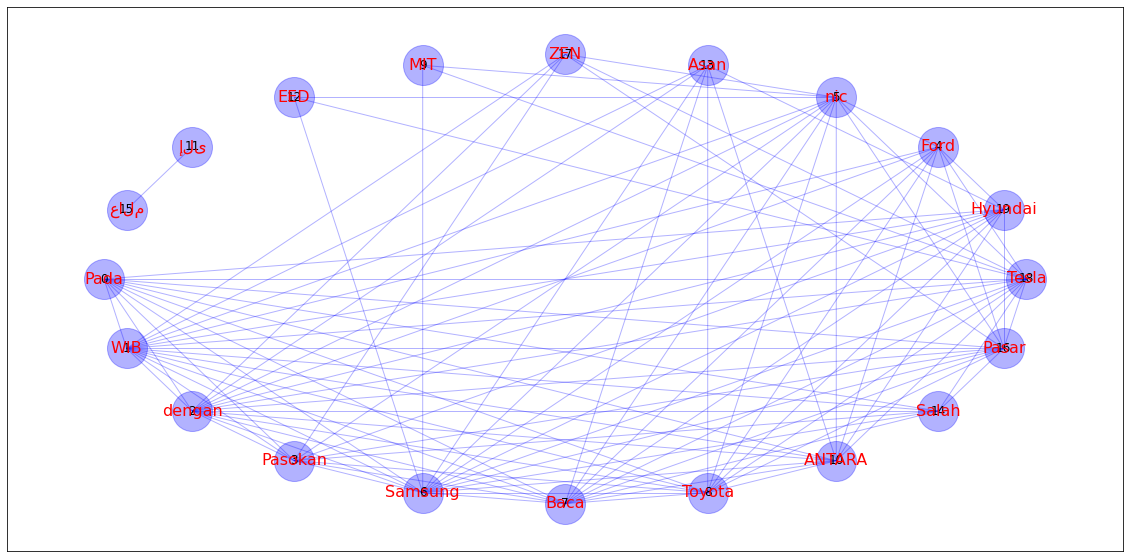

In [15]:
plt.figure(figsize=(20,10))
graph, weight = adj, adj_weight / max(adj_weight)

labels = map(chr, range(65, 65+len(graph)))

draw_graph(graph, adj_weight / max(adj_weight), node_labels=company_names)

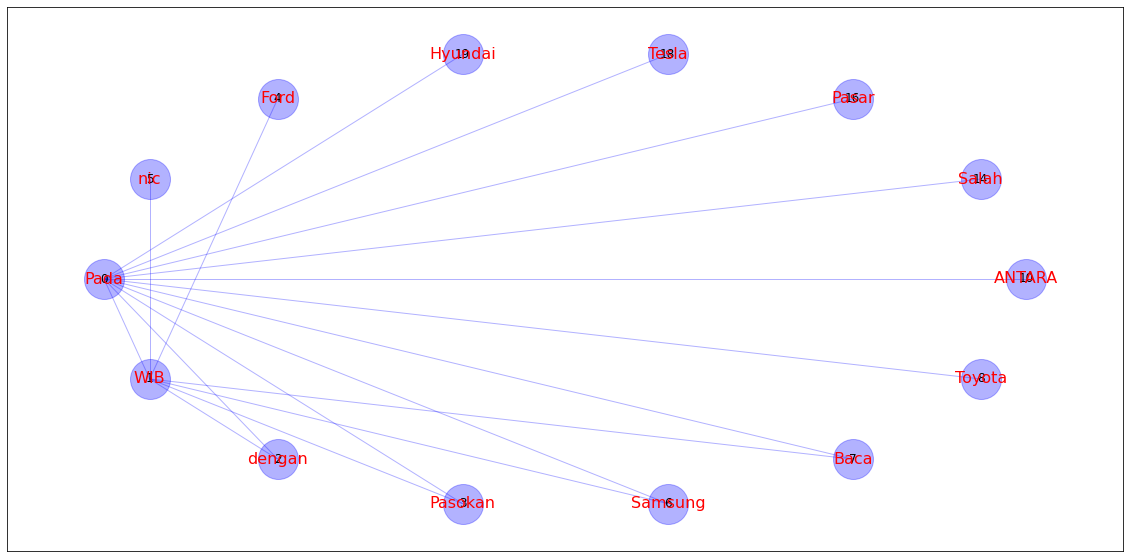

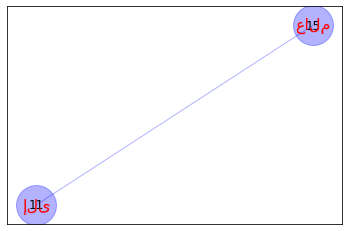

In [16]:
haha=nx.DiGraph()
for edge, w in zip(graph, weight):
    haha.add_edge(edge[0], edge[1], weight=w)

strongs = sorted(nx.strongly_connected_components(haha), key=len, reverse=True)
plt.figure(figsize=(20, 10))
for strong in strongs:
    draw_graph(haha.subgraph(strong).edges(), weight=list(strong), node_labels=company_names)

In [17]:
def draw_deep_graph(graph, weight, node_labels=None, edge_labels=None, graph_layout='shell',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):

    G=nx.Graph()

    for edge, w in zip(graph, weight):
        G.add_edge(edge[0], edge[1], weight=w)

    g = dgl.DGLGraph(G)
    
    G = g.to_networkx()
    
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    if edge_labels is None:
        edge_labels = range(len(graph))

    edge_labels = dict(zip(graph, edge_labels))
    
    labels_ = {}    
    if node_labels is not None:
        for node in G.nodes():
            labels_[node] = node_labels[node]
    
    
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, label=labels,
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)

    
    nx.draw_networkx_labels(G,graph_pos,labels_,font_size=16,font_color='r')
#     nx.draw_networkx_edge_labels(G, graph_pos, edge_labels=edge_labels, 
#                                  label_pos=edge_text_pos)

    plt.show()
    
    return g, G

f:\paraphrase\paraphraseenv\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


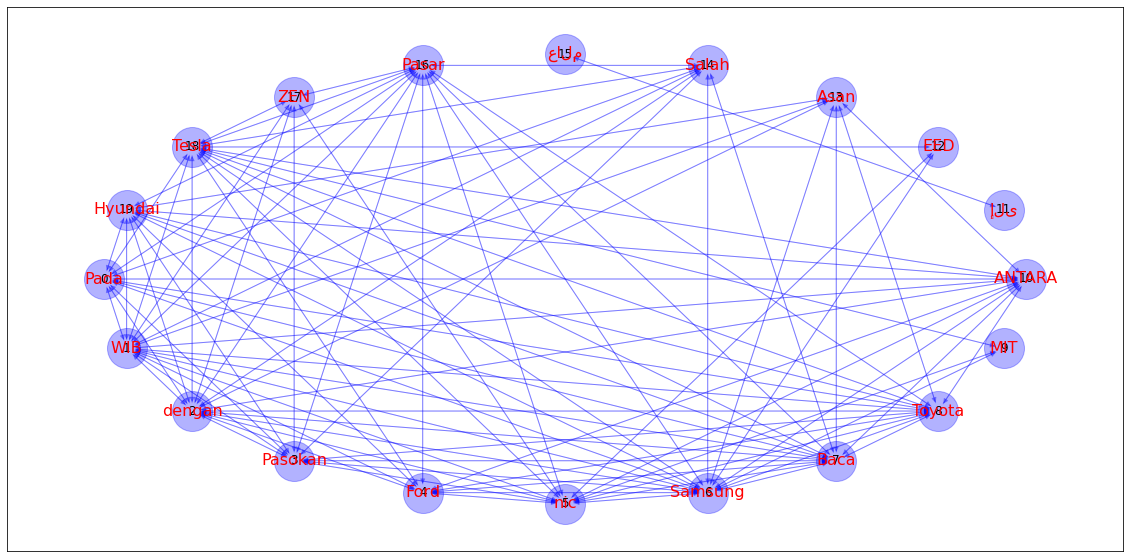

In [18]:
plt.figure(figsize=(20,10))
graph, weight = adj, adj_weight / max(adj_weight)

labels = map(chr, range(65, 65+len(graph)))

small_g, large_G = draw_deep_graph(graph, adj_weight / max(adj_weight), node_labels=company_names)

In [19]:
N = len(thirty_sorted_freq_dict)  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations

small_g.ndata['pv'] = torch.ones(N) / N
small_g.ndata['deg'] = small_g.out_degrees(small_g.nodes()).float()

In [20]:
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

In [21]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

In [22]:
import dgl.function as fn

def pagerank_func(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [23]:
for k in range(K):
    # Uncomment the corresponding line to select different version.
    # pagerank_naive(g)
    # pagerank_batch(g)
    # pagerank_level2(g)
    pagerank_func(small_g)
print(small_g.ndata['pv'])

tensor([0.0500, 0.0665, 0.0665, 0.0505, 0.0460, 0.0613, 0.0730, 0.0622, 0.0581,
        0.0194, 0.0503, 0.0500, 0.0194, 0.0342, 0.0382, 0.0500, 0.0584, 0.0307,
        0.0654, 0.0500])


In [24]:
rank_dict = dict(zip(company_names, small_g.ndata['pv']))

In [25]:
sorted_rank_dict = {k: v for k, v in sorted(rank_dict.items(), key=lambda item: item[1], reverse=True)}

In [26]:
sorted_rank_dict

{'Samsung': tensor(0.0730),
 'WIB': tensor(0.0665),
 'dengan': tensor(0.0665),
 'Tesla': tensor(0.0654),
 'Baca': tensor(0.0622),
 'nic': tensor(0.0613),
 'Pasar': tensor(0.0584),
 'Toyota': tensor(0.0581),
 'Pasokan': tensor(0.0505),
 'ANTARA': tensor(0.0503),
 'Hyundai': tensor(0.0500),
 'إلى': tensor(0.0500),
 'عالم': tensor(0.0500),
 'Pada': tensor(0.0500),
 'Ford': tensor(0.0460),
 'Salah': tensor(0.0382),
 'Asan': tensor(0.0342),
 'ZEN': tensor(0.0307),
 'MIT': tensor(0.0194),
 'EED': tensor(0.0194)}